<a href="https://colab.research.google.com/github/joshualewin6/Colab-Notebook/blob/main/JoshLewiU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GDP per Capita and Life Expectancy Around the World
##Intro
It should come as no surprise that these two have a correlation, since having money isn't everything, but not having it sure is. A poorer country has less access to healthcare, education, food, water, and other basic determining factors of quality of life, and by extension the life expectancy. I want to figure the kind of relation it is, and how closely it's correlated. So, we're going to make a model. Let's import our libraries.

In [33]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import math

from scipy.interpolate import PchipInterpolator

## The Data
I pulled some data from a table in Our World In Data which has the 2022 GDP per capita and life expectancy data for many countries, visualized below in table and scatterplot form.

In [34]:
#reads the data
url_life = 'https://raw.githubusercontent.com/joshualewin6/Colab-Notebook/refs/heads/main/life-expectancy-vs-gdp-per-capita%20-%20life-expectancy-vs-gdp-per-capita.csv'
life = pd.read_csv(url_life)

#removes countries with missing entries, no longer existing countries, continents, and a country with bad life expectancy data
life = life.query('life_expectancy > 30 and gdp_per_capita > 0 and population < 2000000000')

#removes another country with faulty life expectancy data
life = life.query('life_expectancy > 65 or gdp_per_capita < 20000')

#estimates and calculations of gdp per capite vary, this is a particular one, see https://ourworldindata.org/grapher/life-expectancy-vs-gdp-per-capita?tab=table
life

,Entity,Code,Year,life_expectancy,gdp_per_capita,900793-annotations,population,owid_region
0,Afghanistan,AFG,2022,65.6170,1357.9878,NaN,40578846.0,NaN
3,Albania,ALB,2022,78.7688,12978.1010,NaN,2827615.0,NaN
4,Algeria,DZA,2022,76.1289,13506.4440,NaN,45477391.0,NaN
9,Angola,AGO,2022,64.2455,6118.9050,NaN,35635028.0,NaN
12,Argentina,ARG,2022,75.8061,18292.3180,NaN,45407904.0,NaN
...,...,...,...,...,...,...,...,...
276,Venezuela,VEN,2022,72.5656,5267.1753,NaN,28213016.0,NaN
277,Vietnam,VNM,2022,74.5025,8050.3590,NaN,99680656.0,NaN
283,Yemen,YEM,2022,67.9517,1959.3195,NaN,38222880.0,NaN
285,Zambia,ZMB,2022,65.2791,3342.4214,NaN,20152934.0,NaN


<Axes: xlabel='gdp_per_capita', ylabel='life_expectancy'>

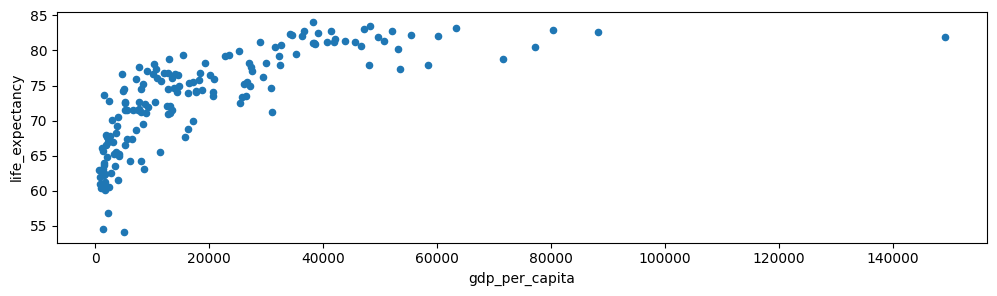

In [35]:
life.plot(x="gdp_per_capita", y="life_expectancy", figsize=(12, 3), kind="scatter")

##The Model
The data shown above is very obviously logarithmic, so I'm doing a distributional model in which the mean is a deterministic log function with normal distribution for the x=1 intercept and normal distribution for the coefficient of the log, and the standard deviation is a simple HalfCauchy, since there doesn't appear to be much deviation in the standard deviation. The likelihood is normal for simplicity. The values for mu were chosen based on what I expected a gdp per capita to life expectancy function would look like, and all three sigma values, are just to provide the model enough room to work with. I left them relatively high so that it was maximally influenced by the data as opposed to my assumptions. Let's run it with these priors and see how it goes.

In [36]:
with pm.Model() as model_life:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=20, sigma=100)
    β = pm.Normal("β", mu=5.5, sigma=20)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * pm.math.log(life.gdp_per_capita))

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 40)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=life.life_expectancy)

    #inference data object
    idata_life = pm.sample()

Output()

Output()

No divergences, nice.
##Analysis
It's time to visualize the results to make sure our model did what we wanted it to and graphed a good mean line without issue.

In [37]:
pm.sample_posterior_predictive(idata_life, model=model_life,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Life Expectancy')

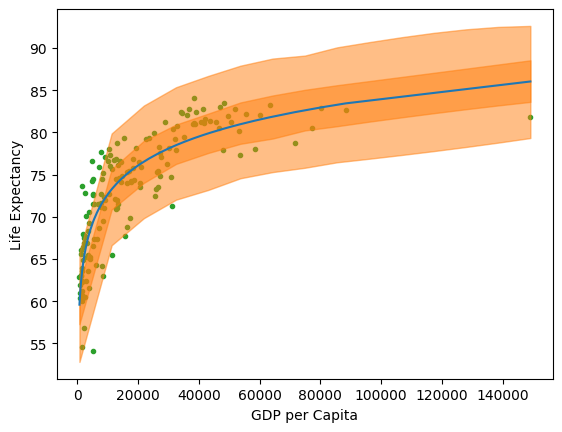

In [38]:
mean_line = idata_life.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
gdps = np.random.normal(life.gdp_per_capita.values, 0.01)
idx = np.argsort(gdps)
x = np.linspace(gdps.min(), gdps.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_life.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(gdps[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(life.gdp_per_capita, life.life_expectancy, "C2.", zorder=-3)
ax.plot(life.gdp_per_capita.to_numpy()[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("GDP per Capita")
ax.set_ylabel("Life Expectancy")

The graph looks perfect except for one thing, from about 1000 to 10000, the mean line is outside the quartile range. What happened? Well, it's actually nothing to worry about; the graphing software is just displaying the HDI bounds using linear approximations between certain x-values, thus creating that error looking thing. There's no issue, so ignore it.

<Axes: xlabel='y_pred'>

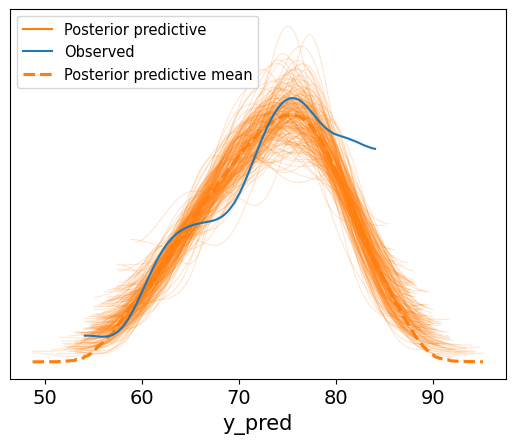

In [39]:
az.plot_ppc(idata_life, num_pp_samples=200, colors=["C1", "C0", "C1"])

The ppc check doesn't perfectly match the data, but it isn't supposed to exactly, and I have reasons for the differences, so I can confidenly say this model is at least somewhat good.
##Conclusion
I think there's some interesting explanations for why the observable data doesn't match the posterior predictive. First of all, there are more countries with life expectancy 80+, which is mildly problematic for the accuracy of the model. My theory for why this is the case is that countries with good enough practices and gdp per capita's hit an upper life barrier (around 87-83 depending on the country) which an arbitrary grouping of humans can't reasonably exceed, so the life expectancy ends up peaking in the 80-85 range and leading to an inadequate decline in the pdf in that range. I don't know how a model can account for this, but setting a soft upper limit in a future model could be beneficial. The overprediction in the model for life expectancies in the 65-72 range is likely due to the fact that it can't account for income disparities. That is, there's lots of rich countries and poor countries, but not so many in the middle, and thus, the same holds for life expectancy, many long, many short, few in the middle. Perhaps a better model in the future would be hierarchical and have categories for low and high income, but that may downplay the general trend from low to high. In any case, it could be good to test out. Overall, the posterior predictive is a great way to predict data, so this model is very good, and would be difficult, though possible, to improve.